<a href="https://colab.research.google.com/github/celikn/GEE_Repository/blob/main/ChangeDetection_TorchGeo_OSCD_Dataset_20220416_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch -q

     |████████████████████████████████| 88 kB 2.8 MB/s 
     |████████████████████████████████| 376 kB 10.7 MB/s 
     |████████████████████████████████| 58 kB 4.0 MB/s 


In [2]:
!pip install torchgeo

     |████████████████████████████████| 204 kB 6.8 MB/s 
     |████████████████████████████████| 1.0 MB 60.7 MB/s 
     |████████████████████████████████| 19.3 MB 60.5 MB/s 
     |████████████████████████████████| 408 kB 43.5 MB/s 
     |████████████████████████████████| 582 kB 53.5 MB/s 
     |████████████████████████████████| 493 kB 44.1 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 16.7 MB 417 kB/s 
     |████████████████████████████████| 6.3 MB 32.1 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 
     |████████████████████████████████| 112 kB 61.0 MB/s 
     |████████████████████████████████| 136 kB 54.2 MB/s 
     |████████████████████████████████| 1.1 MB 57.1 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 12.7 MB/s 
     |████████████████████████████████| 271 kB 46.5 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-

In [3]:
from typing import Dict, List

import kornia.augmentation as K
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader


from torchgeo.datasets import OSCD
import torchgeo.datasets.utils
from torchgeo.samplers import RandomGeoSampler


In [4]:
dataset = OSCD(root="/content/torchgeotest", split="train", download=True, checksum=True)


  0%|          | 0/512716711 [00:00<?, ?it/s]

  0%|          | 0/137873 [00:00<?, ?it/s]

  0%|          | 0/83614 [00:00<?, ?it/s]

In [ ]:
## List file from path 
top="/content/torchgeotest/Onera Satellite Change Detection dataset - Train Labels"
import os
foldernames=[]
for root, dirs, files in os.walk(top, topdown=False):
    for name in dirs:
        print (os.path.join(root, name))
        foldernames.append(name)
foldernames     

In [ ]:
listOfCities= ['dubai',
 'chongqing',
 'cupertino',
 'beihai',
 'nantes',
 'norcia',
 'valencia',
 'rennes',
 'brasilia',
 'pisa',
 'abudhabi',
 'bercy',
 'hongkong',
 'beirut',
 'lasvegas',
 'rio',
 'paris',
 'mumbai',
 'milano',
 'saclay_w',
 'saclay_e',
 'montpellier',
 'bordeaux',
 'aguasclaras']

In [ ]:
listOfTestCities=['dubai',
 'chongqing',
 'norcia',
 'valencia',
 'brasilia',
 'lasvegas',
 'rio',
 'milano',
 'saclay_w',
 'montpellier']

In [5]:
listOfTrainCities=['cupertino',
 'beihai',
 'nantes',
 'rennes',
 'pisa',
 'abudhabi',
 'bercy',
 'hongkong',
 'beirut',
 'paris',
 'mumbai',
 'saclay_e',
 'bordeaux',
 'aguasclaras']

In [6]:
##RGB Version 
# specifying input path to read images
input_path = "/content/torchgeotest/Onera Satellite Change Detection dataset - Images"

img1 = []   # creating list of imagery paths for first set of images 
img2 = []   # creating list of imagery paths for second set of images
label = []  # creating list of change mask paths for the images

for city in listOfTrainCities:
    img1.append(input_path +"/"+ city + "/pair/" + "img1.png")
    img2.append(input_path +"/"+ city + "/pair/" + "img2.png")
    label.append(f"/content/torchgeotest/Onera Satellite Change Detection dataset - Train Labels/{city}/cm/cm.png")


(522, 582, 2)


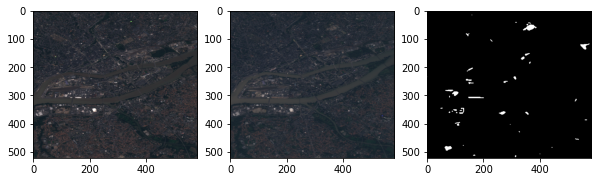

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sample = np.random.randint(0,13) # generate a random number    
im1 = Image.open(img1[sample])
im2 = Image.open(img2[sample])
lab = Image.open(label[sample]).convert('LA')
print(np.array(lab).shape)
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(lab)

Her folder icindeki imageleri image boyutuna bagli olarak 64 pixellik parcalar ayiriyoruz. Asagidaki bilgileri iceren dataframe olusturuyoruz. 
1.   ilk image icin path 
2.   ikinci image icin path 
3.   target binary image path 
4.   patch baslangic bitis row index bilgileri 
5.   patch baslangic bitis col index bilgileri 



In [ ]:
# Below code to divide the whole images into patches of 64X64 
path1 = []
path2 = []
target = []
start_row = []
end_row = []
start_col = []
end_col = []

## takes path of an image and return 64pixel indexs
def arrayOfRowColumns(im1):
    im1content = Image.open(im1)
    im1shape=np.array(im1content).shape
    print(im1shape) ##number of rows and column 
    arrayOf64forImRow=[i for i in range(0,im1shape[0]) if ((i%64==0) and (i+64<im1shape[0]))]
    arrayOf64forImCol=[i for i in range(0,im1shape[1]) if ((i%64==0) and (i+64<im1shape[1]))]
    print(arrayOf64forImRow)
    print(arrayOf64forImCol)

    ##arrayOf64forImRow=[0,64,128,192,256,320,384,448]
    ##arrayOf64forImCol=[0,64,128,192,256,320,384,448]
    return arrayOf64forImRow,arrayOf64forImCol


for im1,im2,lab in zip(img1,img2,label):
    rowInds,colInds = arrayOfRowColumns(im1)
    print(rowInds)
    print (colInds)
    for row in rowInds:
        for col in colInds:
            row_start = row
            row_end = row + 64
            col_start = col
            col_end = col + 64
            
            path1.append(im1)
            path2.append(im2)
            target.append(lab)
            
            start_row.append(row_start)
            end_row.append(row_end)
            
            start_col.append(col_start)
            end_col.append(col_end)
            
df = pd.DataFrame({"path1":path1,"path2":path2,"target":target,"start_row":start_row,"end_row":end_row,"start_col":start_col,"end_col":end_col})



Olusturulan dataframeden her bir image i okuyarak ilgili patchlerden modele gonderecegimiz dataset sinifini olusturuyoruz. 

In [136]:
#Python dataset class to be used for generating images and labels for training the model
class ChangeDatasetRGB():
    def __init__(self,df):
        self.df = df
        
    def __len__(self):
        return (len(self.df))
    
    def __getitem__(self,item):
       
        im1 = np.array(Image.open(self.df.loc[sample,"path1"]))[self.df.loc[sample,"start_row"]:self.df.loc[sample,"end_row"],self.df.loc[sample,"start_col"]:self.df.loc[sample,"end_col"],:]
        im2 = np.array(Image.open(self.df.loc[sample,"path2"]))[self.df.loc[sample,"start_row"]:self.df.loc[sample,"end_row"],self.df.loc[sample,"start_col"]:self.df.loc[sample,"end_col"],:]
        ##target= np.array(Image.open(df_trimmed.loc[sample,"target"]).convert('1')).astype(np.uint8)[self.df.loc[sample,"start_row"]:self.df.loc[sample,"end_row"],self.df.loc[sample,"start_col"]:self.df.loc[sample,"end_col"]]
        target= np.asarray(Image.open(df_trimmed.loc[sample,"target"]).convert('1')).astype(np.uint8)[self.df.loc[sample,"start_row"]:self.df.loc[sample,"end_row"],self.df.loc[sample,"start_col"]:self.df.loc[sample,"end_col"]]

        im1 = torch.tensor((im1/255).transpose(2,1,0),dtype=torch.float) ## imshow le gosterebilemek icin 255 e boluyoruz
        im2 = torch.tensor((im2/255).transpose(2,1,0),dtype=torch.float)
        target = torch.tensor(target,dtype=torch.long)
    
        return (im1,im2,target)

Olusturulan dataframe i changeDataset e gondermeden once validation ve train verisi olarak ikiye ayiriyoruz.


In [191]:
# Seperate data indicess randomly as train and validation 
chosen_idx = np.random.choice(df.shape[0], replace=False, size=round(df.shape[0]/2))
not_chosen_idx = np.setdiff1d(df.index.to_numpy(), chosen_idx)

df_trimmed = df.iloc[chosen_idx]
df_notTrimmed=df.iloc[not_chosen_idx]

df_trimmed=df_trimmed.reset_index(drop=True)
df_notTrimmed=df_notTrimmed.reset_index(drop=True)

train_ds = ChangeDatasetRGB(df_trimmed)  # train dataset
val_ds = ChangeDatasetRGB(df_notTrimmed) # validation dataset


Random sample ile veriyi train etmeden once goruntuleyelim

In [215]:
## Show shape of one sample size for RGB
sample = np.random.randint(0,df_trimmed.shape[0]) # generate a random number
df_trimmed.iloc[sample]

path1        /content/torchgeotest/Onera Satellite Change D...
path2        /content/torchgeotest/Onera Satellite Change D...
target       /content/torchgeotest/Onera Satellite Change D...
start_row                                                  128
end_row                                                    192
start_col                                                  256
end_col                                                    320
Name: 238, dtype: object

Veriyi dataframeden goruntuleyelim 

[512, 576, 0, 64]

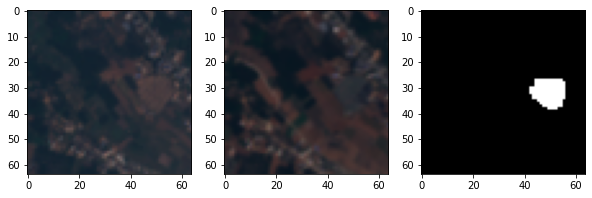

In [193]:
df_trimmed.loc[sample,"path1"]
df_trimmed.loc[sample,"path2"]
df_trimmed.loc[sample,"target"]

fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(np.array(Image.open(df_trimmed.loc[sample,"path1"]))[df_trimmed.loc[sample,"start_row"]:df_trimmed.loc[sample,"end_row"],df_trimmed.loc[sample,"start_col"]:df_trimmed.loc[sample,"end_col"]])
ax[1].imshow(np.array(Image.open(df_trimmed.loc[sample,"path2"]))[df_trimmed.loc[sample,"start_row"]:df_trimmed.loc[sample,"end_row"],df_trimmed.loc[sample,"start_col"]:df_trimmed.loc[sample,"end_col"]])
ax[2].imshow(np.array(Image.open(df_trimmed.loc[sample,"target"]))[df_trimmed.loc[sample,"start_row"]:df_trimmed.loc[sample,"end_row"],df_trimmed.loc[sample,"start_col"]:df_trimmed.loc[sample,"end_col"]])

[df_trimmed.loc[sample,"start_row"],df_trimmed.loc[sample,"end_row"],df_trimmed.loc[sample,"start_col"],df_trimmed.loc[sample,"end_col"]]

Ayni veriyi dataset objesinden cekelim

In [194]:
im1,im2,target = train_ds[sample] # read a random sample
im1.shape,im2.shape,target.shape,sample  # check shape

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]), torch.Size([64, 64]), 306)

In [218]:

im1_val,im2_val,target_val = val_ds[sample] # read a random sample
im1_val.shape,im2_val.shape,target_val.shape,sample  # check shape



(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]), torch.Size([64, 64]), 238)

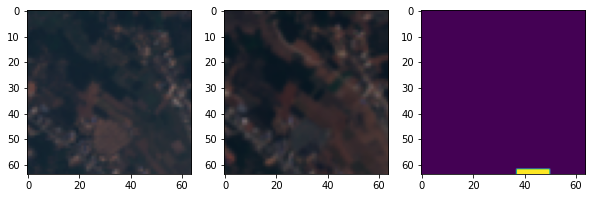

In [219]:
# plot the image1, image2 and the change mask

fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow((im1.numpy()).transpose(1,2,0))
ax[1].imshow((im2.numpy()).transpose(1,2,0))
ax[2].imshow(target_val.numpy())

Benzer sekilde validation verilerinden goruntuleme yapalim 

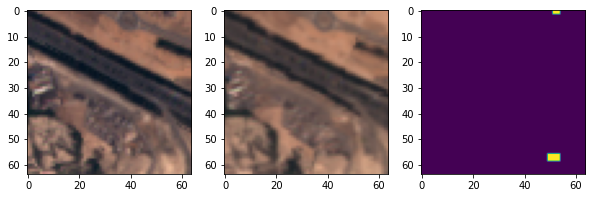

In [214]:
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow((im1_val.numpy()).transpose(1,2,0))
ax[1].imshow((im2_val.numpy()).transpose(1,2,0))
ax[2].imshow(target_val.numpy())



Check all images shapes

In [ ]:

alltrains=[[train_ds[i][0].shape,train_ds[i][1].shape,train_ds[i][2].shape] for d,i  in enumerate(range(len(df_trimmed)))]
alltrains


In [ ]:
allvals=[[val_ds[i][0].shape,val_ds[i][1].shape,val_ds[i][2].shape] for d,i  in enumerate(range(len(df_notTrimmed)))]
allvals

Train edilmis bir model cekelim

In [197]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
model = smp.Unet('resnet34',encoder_depth=3,decoder_channels=(64, 64, 16)) # build a base model based on Unet architecture with a resnet34 encoder 

Haziladigimiz datasetleri train loader a ekleyelim

In [198]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds,batch_size=256, shuffle=True)  # train dataset to train dataloader
val_dl = DataLoader(val_ds,batch_size=256, shuffle=False)  # valid dataset to valid dataloader

In [199]:
# ChangeNet model

class ChangeNet(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.encoder = model.encoder  #model encoder
        self.decoder = model.decoder  #model decoder
        self.head = model.segmentation_head  #segmentation head for generation of change mask
        
    def forward(self,x1,x2):
        enc1 = self.encoder(x1)  # get latent features of image1
        enc2 = self.encoder(x2)  # get latent features of image2
        encoder_out = []
        for i in range(len(enc1)):
            encoder_out.append(torch.add(enc1[i],enc2[i])) # Add the latent features and append them to a list
        decoder_out = self.decoder(*encoder_out) # Pass the latent features through a decoder
        out = self.head(decoder_out) # Pass the decoder output through the segmentation head to generate change mask
        return out

In [200]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')  #Training on gpu if available

In [201]:
change_model = ChangeNet(model).to(device) #migrating model to device

from tqdm.notebook import tqdm ## progress bar

criterion = torch.nn.BCEWithLogitsLoss().to(device)   #loss function is BCE loss since it is binary classification
optimizer = torch.optim.Adam(change_model.parameters(), lr=0.0001)

for epoch in tqdm(range(10)):  # Number of epochs = 5
    
    epoch_loss = []
    # Iterate over data.
        
    change_model.train() # setting model state to train
    for x1,x2,target in tqdm(train_dl,total=len(train_dl)):
        
        x1 = x1.to(device)  #migrating inputs to device
        x2 = x2.to(device)  #migrating inputs to device
        target = target.to(device)  #migrating inputs to device
                
        # zero the parameter gradients
        optimizer.zero_grad()   #resetting the optimizer

        # forward
        outputs = change_model(x1,x2)  # generating model predictions
        loss = criterion(outputs.squeeze(), target.float()) # evaluating loss

        # backward + optimize only if in training phase
        
        loss.backward()  # calculating gradients
        optimizer.step()  # using optimizer to recalculate parameters
        epoch_loss.append(loss.item())
    
    print(f"Epoch {epoch}, Loss:",np.array(epoch_loss).mean())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0, Loss: 0.724159836769104


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.623864471912384


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2, Loss: 0.5680615901947021


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3, Loss: 0.5272748668988546


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4, Loss: 0.49441327651341754


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5, Loss: 0.4671735167503357


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6, Loss: 0.4428143997987111


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7, Loss: 0.42141348123550415


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8, Loss: 0.40243691205978394


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9, Loss: 0.3854317267735799


Train edilmis modeli drive a kaydedelim

In [202]:
PATH="/content/drive/MyDrive/TrainedModels/pytorch_change_detection_nb__E9L026V2"
torch.save(change_model.state_dict(), PATH)

In [203]:
change_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

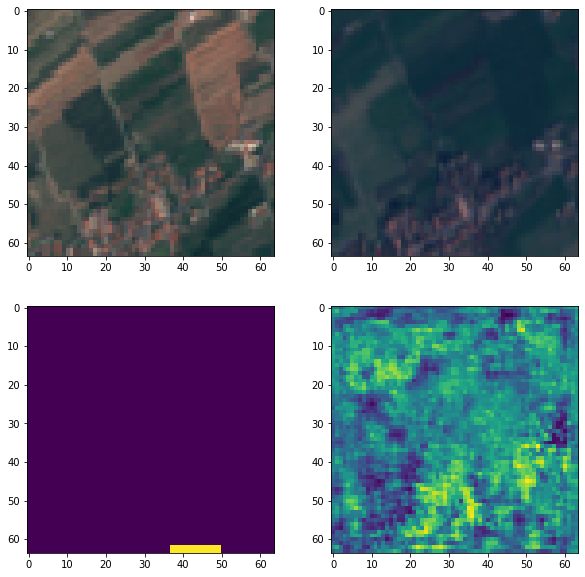

In [238]:
change_model.eval()  #setting model to eval for generating predictions
s = 53 # sample - random
with torch.no_grad():
    #generating prediction & passing the prediction through torch.sigmoid 
    pred_mask = (torch.sigmoid(change_model(val_ds[s][0].unsqueeze(dim=0).to(device),val_ds[s][1].unsqueeze(dim=0).to(device))).squeeze()).detach().cpu().numpy()  


    # displaying sample image1, sample image2, sample ground truth mask, and predicted mask    
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    ax[0][0].imshow(val_ds[s][0].numpy().transpose(1,2,0))
    ax[0][1].imshow(val_ds[s][1].numpy().transpose(1,2,0))
    ax[1][0].imshow(val_ds[s][2].numpy())
    ax[1][1].imshow(pred_mask)